# 💡 Prever é Poder: Risco de Crédito com Inteligência de Dados e Responsabilidade Regulamentar

A concessão de crédito é um dos pilares das fintechs modernas. Saber **quem pode pagar** e **quem representa risco de inadimplência** não é apenas uma questão de algoritmo — é uma decisão que impacta pessoas, negócios e o mercado.

Neste projeto, coloco em prática uma abordagem completa de ciência de dados para prever inadimplência com base em informações reais de crédito. O objetivo é claro: **aumentar a segurança na análise de risco** e **diminuir os falsos negativos**, seguindo diretrizes regulatórias.

> 🔍 Modelo utilizado: **Regressão Logística**, conforme exigência da Superintendência de Banca e Seguros (SBS)

Ao longo dessa jornada, você vai acompanhar:
- A preparação de dados reais de crédito
- A construção de um modelo preditivo interpretável
- A análise dos fatores que mais influenciam o risco
- E a aplicação prática dos resultados para tomada de decisão.

Este projeto vai além de métricas — ele traduz **dados em decisões responsáveis**, com um olhar analítico e humano.

---

## 🛠️ Ferramentas que vamos usar

Para transformar dados brutos em decisões estratégicas, precisamos das ferramentas certas.

Neste projeto, utilizamos um conjunto robusto de bibliotecas do ecossistema Python:

- **Pandas & NumPy** → manipulação e análise eficiente de dados
- **Matplotlib & Seaborn** → visualizações claras, informativas e persuasivas
- **Scikit-learn** → desde o pré-processamento até a avaliação do modelo
- **Pipelines e Transformers** → para garantir um fluxo limpo, escalável e reutilizável

Essas ferramentas nos permitem não apenas construir um modelo, mas fazer isso com clareza, replicabilidade e confiança.


In [1]:
# Main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


## 📦 Conhecendo o dataset

Os dados utilizados neste projeto foram disponibilizados por uma agência de crédito e simulam um cenário real de avaliação de risco.

Cada linha representa um cliente e inclui informações como:
- Idade, renda, histórico de crédito e tempo de emprego
- Tipo de moradia e intenção do empréstimo
- Valor solicitado, taxa de juros e percentual do valor em relação à renda

Nosso objetivo é prever a variável `loan_status`, que indica:
- `0` → cliente adimplente
- `1` → cliente inadimplente

Vamos carregar e dar uma primeira olhada nos dados.


In [4]:
# Loading the data
df: pd.DataFrame = pd.read_csv("/content/credit_risk_dataset.csv")

# Viewing samples
df.sample(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
9752,25,64000,MORTGAGE,10.0,MEDICAL,A,5000,7.29,0,0.08,N,2
26895,34,36129,RENT,3.0,DEBTCONSOLIDATION,C,1800,14.22,0,0.05,Y,9
19730,29,35568,MORTGAGE,5.0,DEBTCONSOLIDATION,B,3975,10.99,0,0.11,N,7
11899,24,71004,MORTGAGE,8.0,DEBTCONSOLIDATION,D,5000,14.96,1,0.07,Y,3
17881,28,73000,RENT,0.0,PERSONAL,B,32000,11.99,1,0.44,N,9


## 🧪 Primeira leitura dos dados

Antes de qualquer gráfico ou modelagem, precisamos entender **como os dados estão estruturados**:

- Quantas entradas e colunas temos?
- Quais os tipos de dados?
- Há valores ausentes ou formatos inadequados?

Essa primeira leitura já antecipa os principais desafios que vamos encarar no pré-processamento.


In [6]:
# General DataFrame Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### 🔎 Procurando dados ausentes

Dados incompletos são comuns em cenários reais. Precisamos saber:

- Onde estão os valores faltantes?
- Quantos são e em que colunas ocorrem?
- Eles impactam diretamente o modelo ou podem ser tratados com estratégias simples?

Vamos listar os campos com dados nulos.


In [7]:
# Null values ​​by column
df.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


## 🧼 Tratando valores ausentes

Antes de seguir com visualizações e modelagem, é fundamental resolver os dados ausentes.

- `person_emp_length`: vamos preencher com `0`, assumindo que os registros representam pessoas desempregadas ou sem informação sobre tempo de trabalho.
- `loan_int_rate`: vamos imputar com a média da taxa de juros **de acordo com o `loan_grade`** — uma abordagem coerente com a lógica de risco e classificação de crédito.

In [10]:
# Filling 'person_emp_length' with 0
df['person_emp_length'].fillna(0, inplace=True)

# Filling 'loan_int_rate' with the average per loan_grade
mean_for_int = df.groupby('loan_grade')['loan_int_rate'].mean()
df['loan_int_rate'].fillna(df['loan_grade'].map(mean_for_int), inplace=True)

### 📊 Resumo estatístico das variáveis numéricas

Agora vamos analisar as principais estatísticas de cada coluna numérica:

- Média, mediana, mínimo e máximo
- Dispersão dos dados
- Possíveis valores fora da realidade (outliers)

Esse é um passo essencial para **conhecer o comportamento dos dados antes de tentar prever algo com eles**.


In [8]:
# Estatísticas básicas
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


### 🚨 Investigando valores improváveis

Durante a leitura inicial, identificamos alguns possíveis *outliers extremos*:

- Clientes com **idade acima de 100 anos**
- Pessoas com **mais de 50 anos de emprego**

Vamos verificar quantos casos assim existem. Em geral, esses valores são erros ou exceções que podem distorcer o modelo.


In [9]:
# Extreme cases of age and employment time
print("Clients over 100 years old:", df[df['person_age'] > 100].shape[0])
print("Clients over 50 years of employment:", df[df['person_emp_length'] > 50].shape[0])

Clients over 100 years old: 5
Clients over 50 years of employment: 2


## 🚨 Removendo outliers extremos

Alguns registros apresentam valores **fora da realidade prática**, como:
- Clientes com mais de 100 anos de idade
- Pessoas com mais de 50 anos de tempo de trabalho

Esses casos são raros e podem distorcer o modelo. Vamos removê-los do nosso conjunto de dados.

In [11]:
# Filtering records with plausible age and employment time
df = df[(df['person_age'] <= 100) & (df['person_emp_length'] <= 50)]

### ✅ Verificando o DataFrame após o tratamento

Vamos conferir se:
- Os valores ausentes foram tratados corretamente
- Os dados extremos foram removidos
- A estrutura está pronta para seguir para a parte gráfica


In [12]:
# Checking post-processing structure
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32574 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   person_emp_length           32574 non-null  float64
 4   loan_intent                 32574 non-null  object 
 5   loan_grade                  32574 non-null  object 
 6   loan_amnt                   32574 non-null  int64  
 7   loan_int_rate               32574 non-null  float64
 8   loan_status                 32574 non-null  int64  
 9   loan_percent_income         32574 non-null  float64
 10  cb_person_default_on_file   32574 non-null  object 
 11  cb_person_cred_hist_length  32574 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


## 📦 Visualizando possíveis outliers com boxplots

Com os dados limpos, vamos agora explorar a distribuição das variáveis numéricas.

Os **boxplots** são ideais para:
- Identificar outliers com clareza
- Comparar a dispersão entre diferentes variáveis
- Visualizar assimetrias que podem influenciar a modelagem

Vamos exibir todos os gráficos em um único grid, facilitando a leitura e análise comparativa.


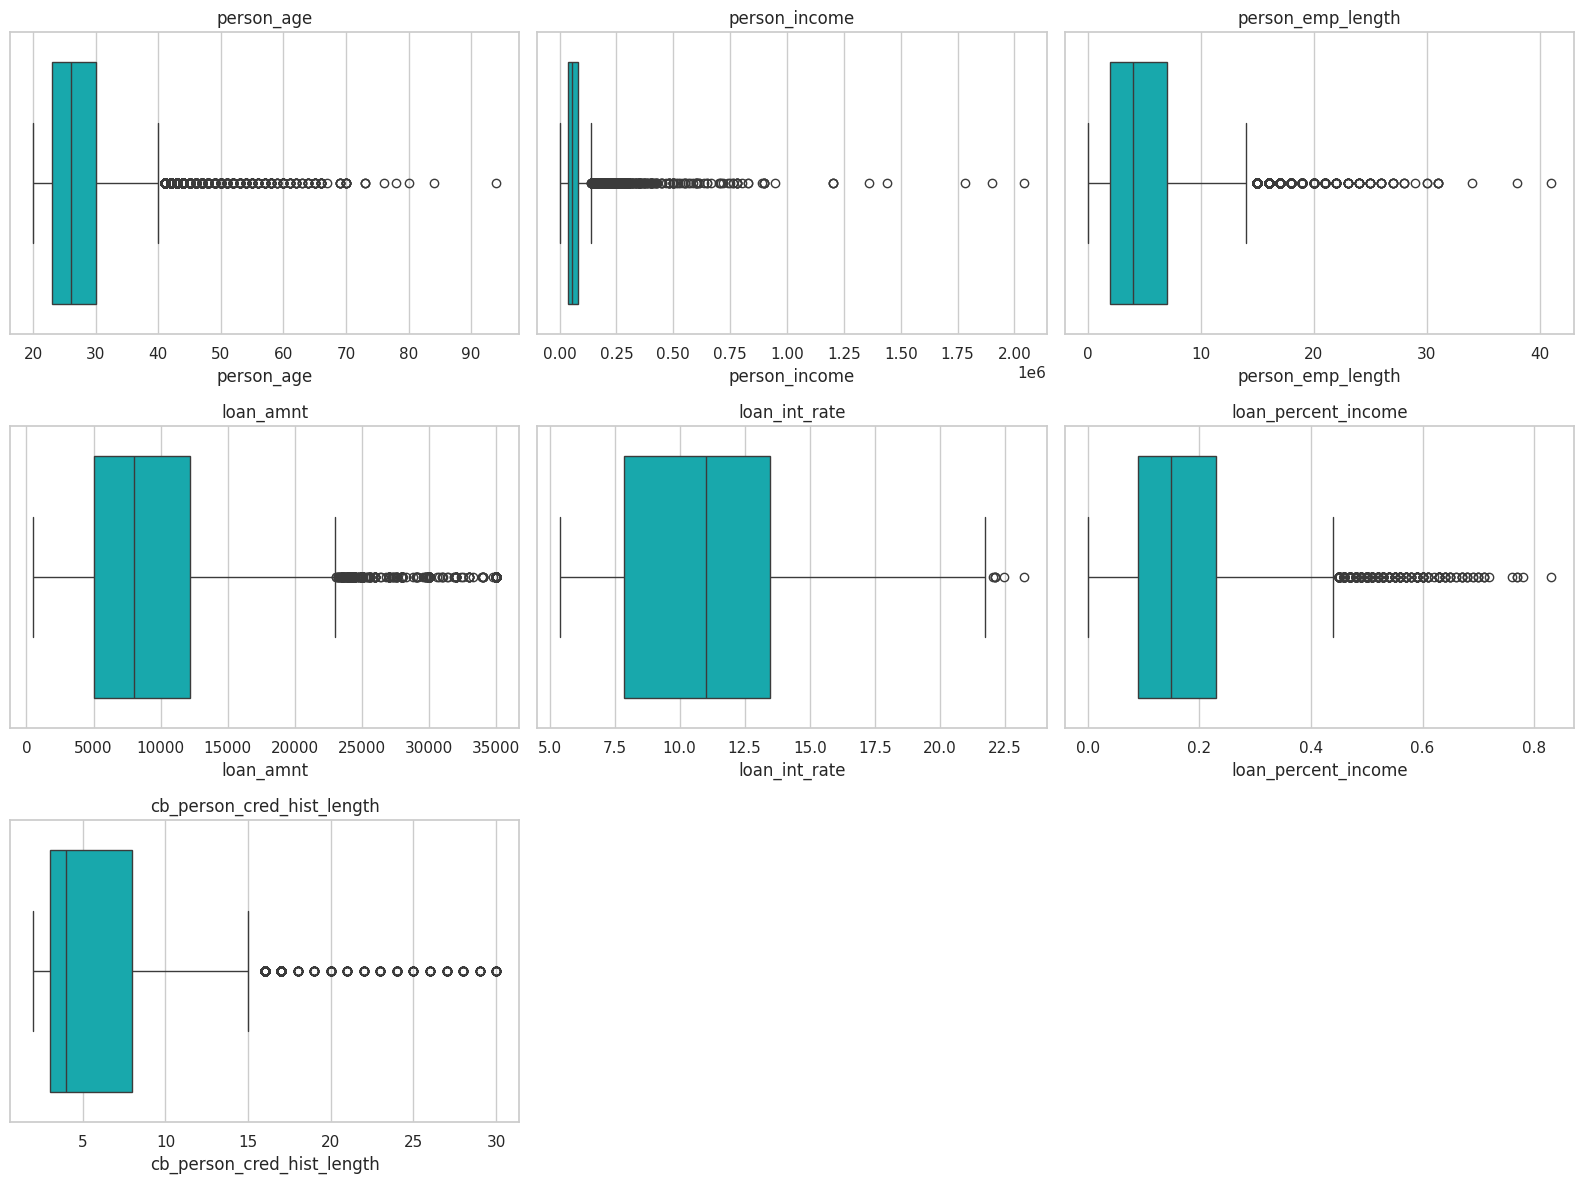

In [13]:
# Selecting numeric columns
numeric_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length'
]

# Creating boxplot grid
plt.figure(figsize=(16, 12))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, idx)
    sns.boxplot(x=df[col], color="#00BFC4")
    plt.title(col)
plt.tight_layout()
plt.show()

## 📊 Distribuição das variáveis com histogramas

Agora vamos explorar **como os dados estão distribuídos**.

Enquanto os boxplots ajudam a identificar valores extremos, os **histogramas** mostram a densidade e a forma geral da distribuição. Com eles, conseguimos identificar:

- Assimetrias (como cauda longa à direita ou esquerda)
- Faixas com maior frequência
- Distribuições que precisam de transformação (ex: `log(income)`)

Vamos visualizar todos os histogramas de forma clara.


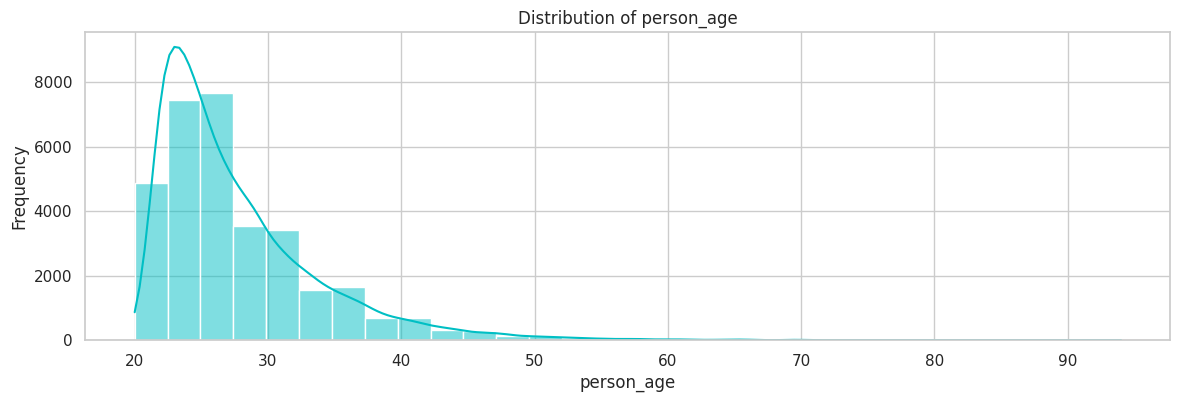

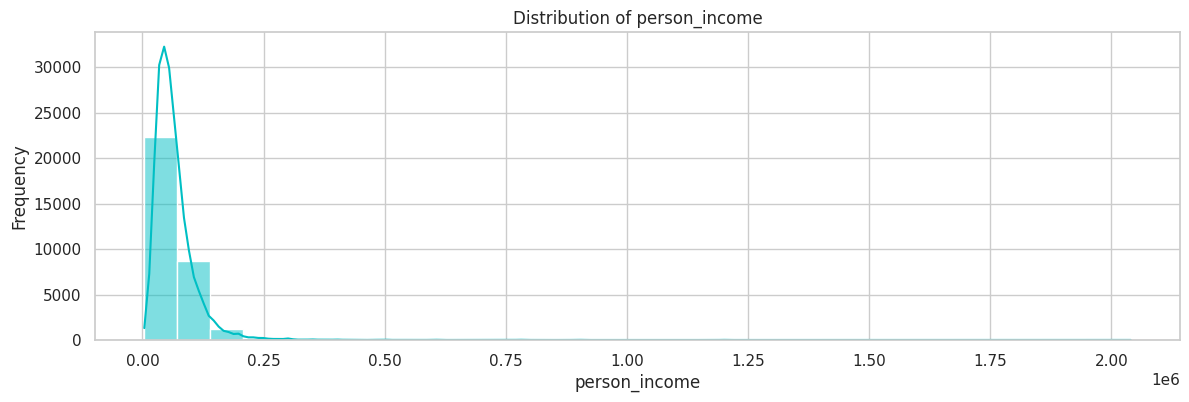

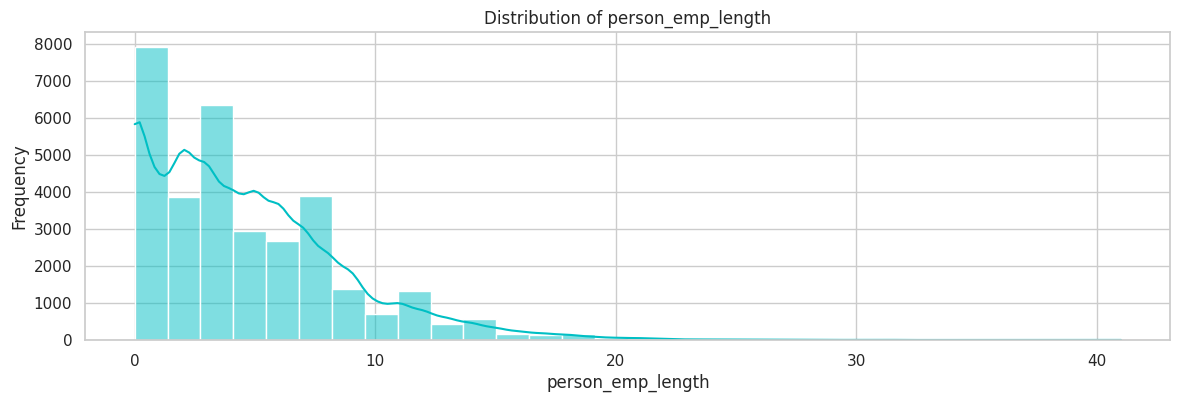

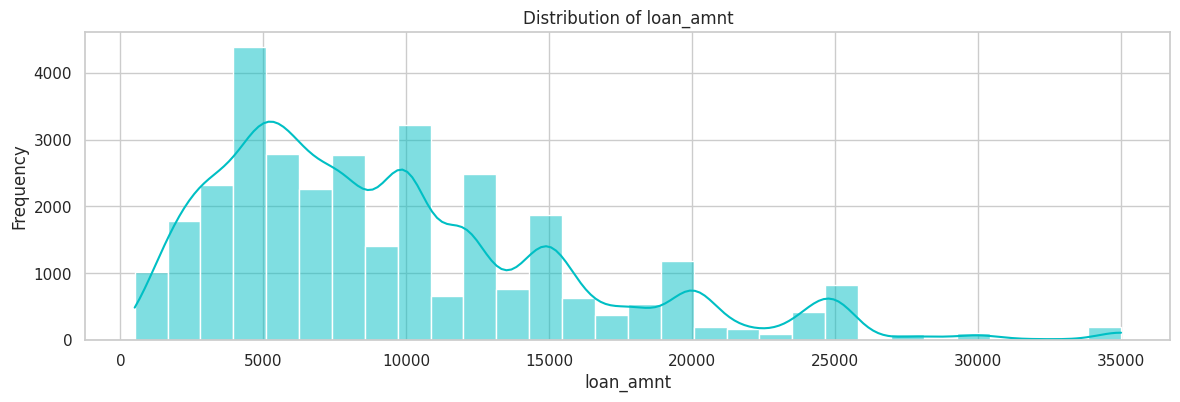

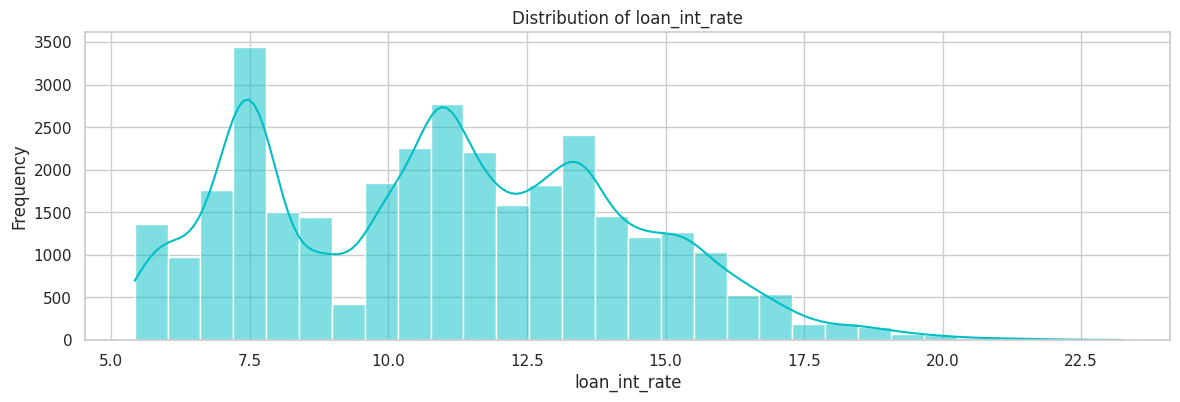

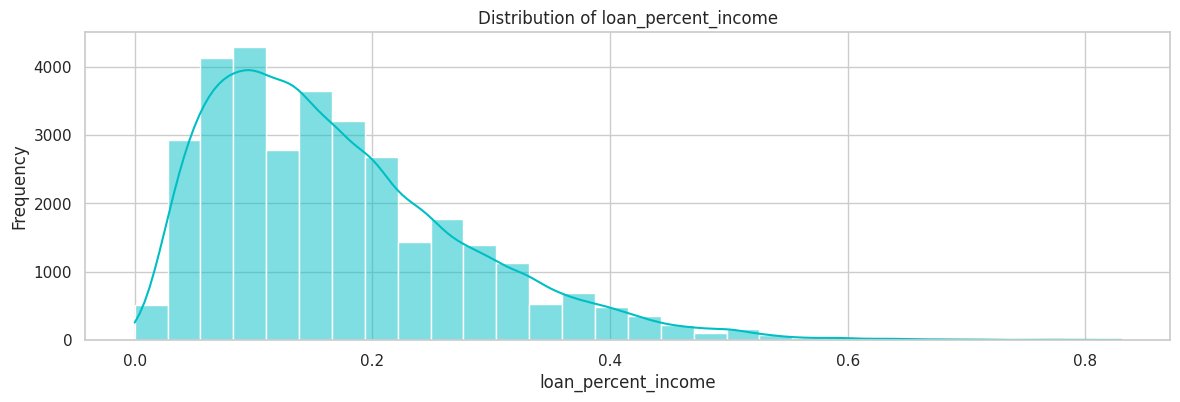

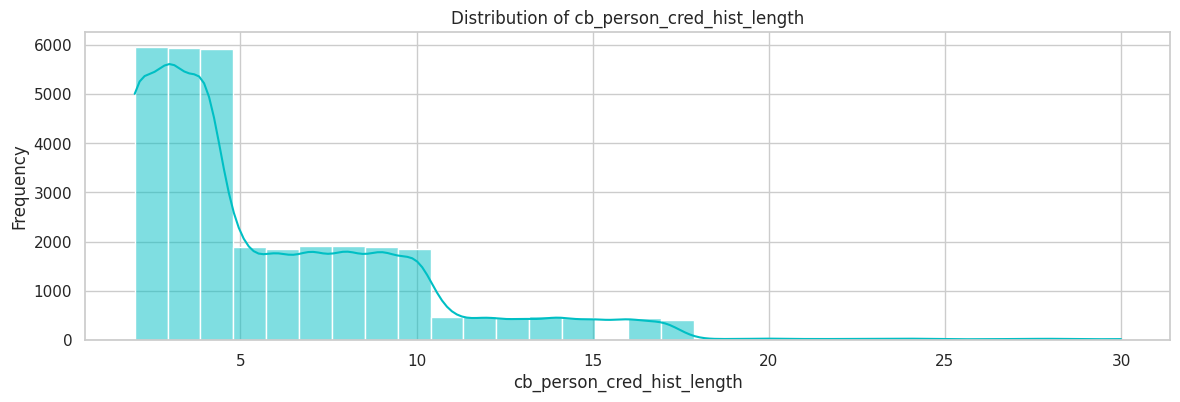

In [15]:
# Histograms for numeric variables
for col in numeric_cols:
  plt.figure(figsize=(14, 4))
  sns.histplot(df[col], bins=30, kde=True, color="#00BFC4")
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.grid(True)
  plt.show()

## 🔁 Transformando `person_income` com log

A distribuição de `person_income` apresenta uma cauda longa — muitos valores pequenos e poucos extremamente altos.

Para melhorar a estabilidade do modelo e reduzir a influência de outliers, aplicamos uma **transformação logarítmica**:

- Compressa valores extremos
- Preserva a ordem dos dados
- Torna a variável mais simétrica para modelos lineares

A nova variável será `log_income`.


In [16]:
# Applying log(1 + income) to avoid log(0)
df['log_income'] = np.log1p(df['person_income'])

### 📊 Comparando a distribuição antes e depois do log

Vamos visualizar a diferença entre a variável original (`person_income`) e a transformada (`log_income`). Essa transformação ajuda o modelo a lidar melhor com a variabilidade dos dados.


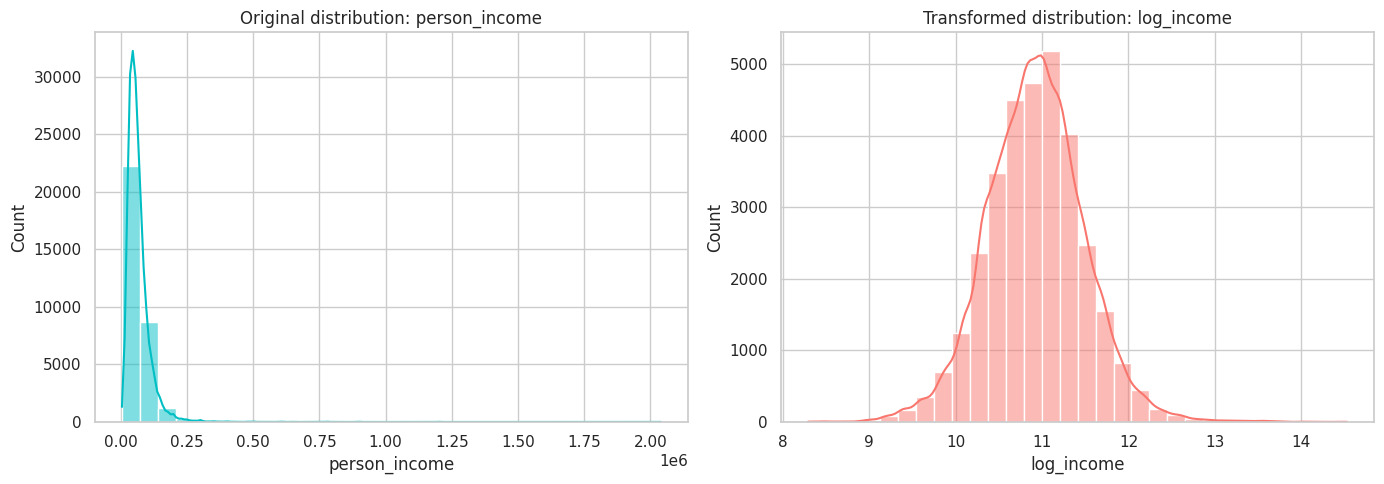

In [17]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['person_income'], bins=30, kde=True, color="#00BFC4")
plt.title("Original distribution: person_income")

plt.subplot(1, 2, 2)
sns.histplot(df['log_income'], bins=30, kde=True, color="#F8766D")
plt.title("Transformed distribution: log_income")

plt.tight_layout()
plt.show()

## 🔗 Matriz de correlação entre variáveis numéricas

Agora vamos observar como as variáveis numéricas se relacionam entre si e com a inadimplência (`loan_status`).

- Correlação próxima de **1** indica relação forte e positiva
- Correlação próxima de **-1** indica relação forte e negativa
- Correlação próxima de **0** indica fraca ou nenhuma relação linear

Essa visualização é fundamental para orientar escolhas de variáveis e evitar redundância na modelagem.


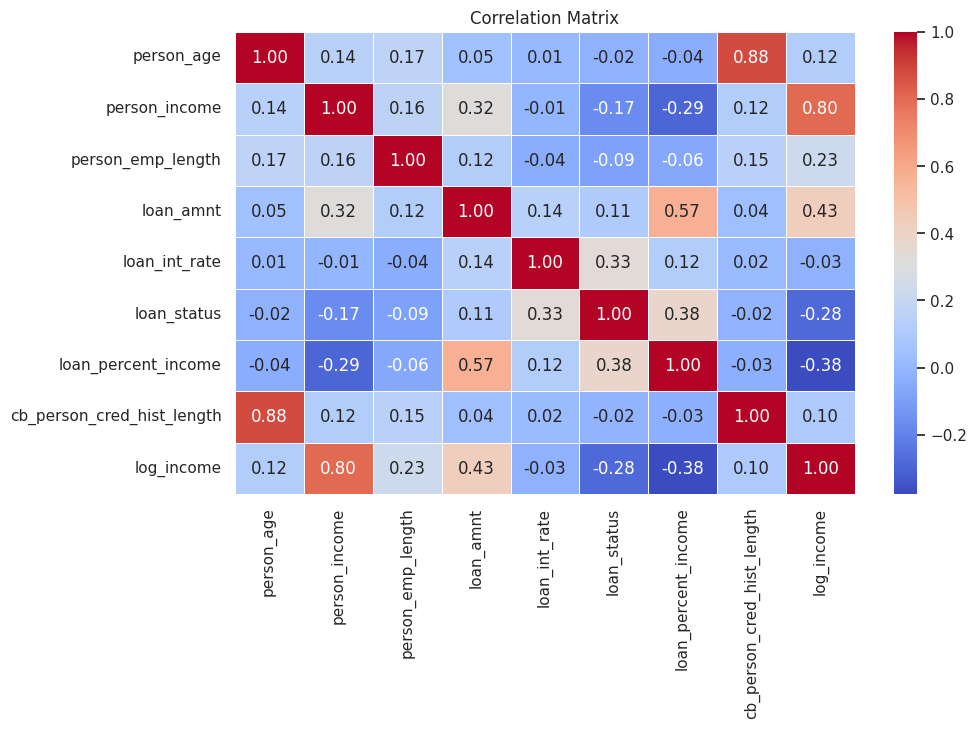

In [18]:
# Correlation matrix
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## 📋 Inadimplência por categoria

Vamos explorar como a inadimplência (`loan_status`) se distribui entre os diferentes valores de:

- `person_home_ownership`: tipo de moradia
- `loan_intent`: finalidade do empréstimo
- `loan_grade`: avaliação de risco da instituição
- `cb_person_default_on_file`: histórico de inadimplência

Essa análise ajuda a descobrir **perfis de maior risco**, que podem ser usados tanto para prever quanto para justificar decisões com base em dados.


In [20]:
# Helper function to generate default rate graphs by category
def plot_default_rate_by_category(df, column):
  plt.figure(figsize=(10, 4))
  default_rate = df.groupby(column)['loan_status'].mean().sort_values(ascending=False)
  sns.barplot(x=default_rate.index, y=default_rate.values, palette="Blues_d")
  plt.title(f'Default rate by {column}')
  plt.ylabel('Default rate')
  plt.xlabel(column)
  plt.xticks(rotation=45)
  plt.ylim(0, 1)
  plt.grid(True, axis='y', linestyle='--', alpha=0.7)
  plt.show()

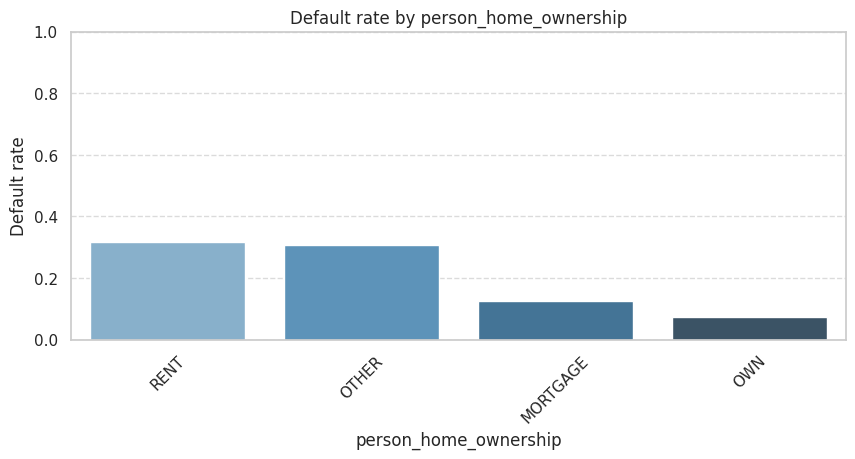

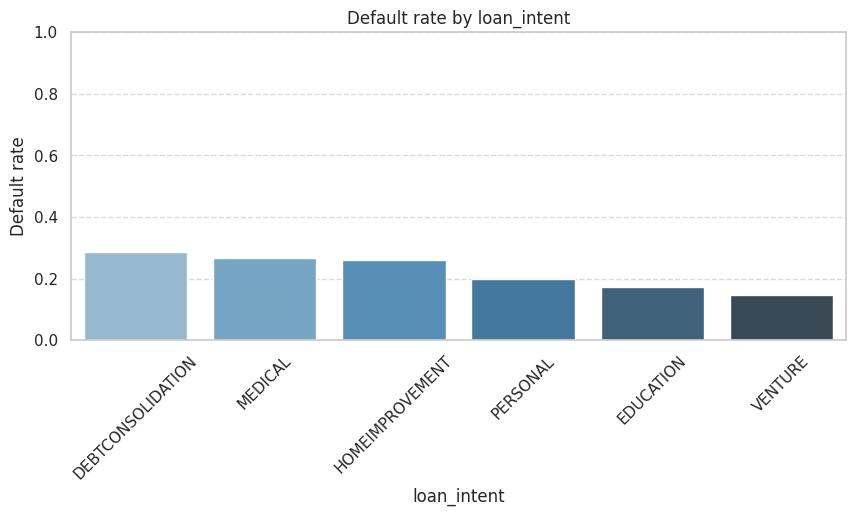

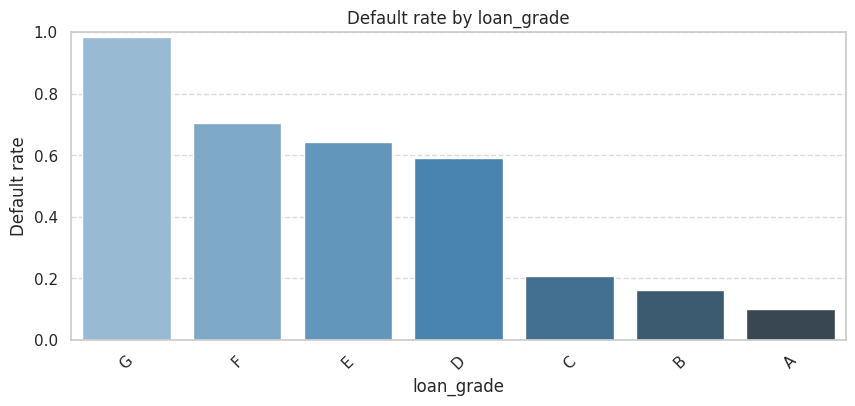

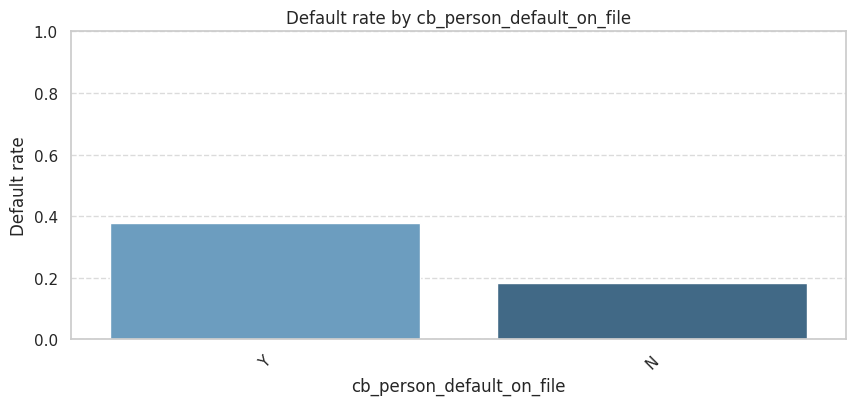

In [21]:
# Analyzing categorical variables
categorical_cols = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

for col in categorical_cols:
    plot_default_rate_by_category(df, col)

## 🧠 O que os dados categóricos nos dizem?

A análise da inadimplência por categoria revela **padrões muito relevantes para o modelo** e reforça hipóteses de risco já conhecidas no setor financeiro:

---

### 📌 `person_home_ownership`
- **Clientes que alugam (`RENT`)** têm uma taxa de inadimplência consideravelmente maior do que os que **possuem imóvel (`OWN`)**.
- Isso pode refletir maior instabilidade financeira ou menor acúmulo de patrimônio.

---

### 📌 `loan_intent`
- Os maiores riscos aparecem nos empréstimos com finalidades **pessoais (`PERSONAL`)**, **médicas (`MEDICAL`)** e **venture** (investimentos de risco).
- Empréstimos para **educação** apresentam a menor inadimplência — o que pode indicar um perfil mais planejado e com retorno esperado.

---

### 📌 `loan_grade`
- A relação é clara: quanto **pior o grade (G, F, E)**, **maior a inadimplência**.
- Já clientes com notas **A ou B** apresentam baixíssimo risco, reforçando que essa variável é excelente candidata a feature importante.

---

### 📌 `cb_person_default_on_file`
- Clientes com **histórico de inadimplência (Y)** são, de fato, mais propensos a reincidir.
- Mas vale notar que a diferença, embora real, não é tão grande quanto se poderia esperar — sinal de que **só esse histórico não deve ser critério exclusivo de decisão**.

---

Esses padrões nos ajudam a:
- Definir features para o modelo
- Justificar decisões baseadas em dados
- Criar filtros ou regras de negócio mais inteligentes no futuro

Agora que compreendemos o comportamento dos dados, vamos prepará-los para o modelo.


## 🛠️ Pré-processamento dos dados

Com os dados explorados e entendidos, agora precisamos prepará-los para a modelagem.

Nessa etapa, vamos:
- Eliminar registros duplicados
- Criar uma variável de renda transformada (`log_income`)
- Selecionar quais variáveis serão usadas como features
- Separar colunas categóricas e numéricas
- Criar um pipeline de transformação com `ColumnTransformer`

Tudo isso para garantir um processo limpo, reutilizável e alinhado com as melhores práticas do mercado.


In [22]:
# Removing duplicate records
print(f"Duplicates before: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Duplicates after: {df.duplicated().sum()}")

Duplicates before: 165
Duplicates after: 0


### 🧩 Separando variáveis categóricas e numéricas

Vamos agora selecionar quais variáveis vão entrar no modelo e agrupá-las conforme o tipo:

- **Numéricas**: variáveis contínuas ou discretas que precisam de normalização
- **Categóricas**: variáveis que serão transformadas via OneHotEncoding

Essa separação facilita a criação de um pipeline claro e reaplicável.


In [23]:
# Defining categorical and numeric columns to use
categorical_features = [
'person_home_ownership',
'loan_intent',
'loan_grade',
'cb_person_default_on_file'
]

numerical_features = [
'person_age',
'loan_amnt',
'loan_int_rate',
'loan_percent_income',
'log_income',
'person_emp_length'
]

### 🔄 Criando o ColumnTransformer

Vamos usar um `ColumnTransformer` para aplicar transformações diferentes em colunas diferentes:

- **Numéricas**: padronizadas com `StandardScaler`
- **Categóricas**: codificadas com `OneHotEncoder`

Esse passo é essencial para manter a coerência no fluxo de treino/teste e garantir que o modelo receba os dados no formato correto.


In [24]:
from sklearn.pipeline import Pipeline

# Pipeline for categorical columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for numeric columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Putting it all together with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## 📊 Separação entre treino e teste

Vamos dividir nosso dataset em:
- **80% para treino**
- **20% para teste**

Usamos o parâmetro `stratify=y` para garantir que a proporção de inadimplentes (classe 1) seja mantida em ambos os conjuntos — isso evita viés na hora de avaliar a performance do modelo.


In [25]:
# Separating features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 🤖 Pipeline final com Regressão Logística

Agora vamos criar o pipeline completo que:
1. Aplica o pré-processamento (normalização + codificação)
2. Treina o modelo de regressão logística com os dados de treino

Isso garante que todo o fluxo (inclusive transformações) seja aplicado de forma integrada e segura.


In [26]:
# Creating the complete pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Training the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age', 'loan_amnt',
                                                   'loan_int_rate',
                                                   'loan_percent_income',
                                                   'log_income',
                                                   'person_emp_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('classifier', LogisticRegression(random_state=42))])

✅ Modelo treinado com sucesso!

Agora vamos para a parte mais importante: **avaliar a performance** do modelo com as métricas certas e ajustar o threshold de decisão usando o **Índice de Youden** — uma técnica que maximiza a sensibilidade e especificidade ao mesmo tempo.


## 🧪 Avaliação inicial do modelo

Com o pipeline treinado, vamos gerar:

- Predições de rótulos (`y_pred`)
- Probabilidades de inadimplência (`y_pred_proba`)

E calcular:
- Acurácia
- Precisão
- Recall
- F1-score
- AUC (Área sob a curva ROC)

Essas métricas juntas nos dão uma visão completa da performance do modelo.


In [27]:
# Predicting labels and probabilities
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculating initial metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"AUC: {auc:.2f}")

Accuracy: 0.87
Precision: 0.76
Recall: 0.57
F1-score: 0.65
AUC: 0.88


## 🎯 Ajustando o threshold com o Índice de Youden

O threshold padrão de 0.5 pode não ser o ideal em problemas de crédito, onde falsos negativos (não prever um inadimplente) são muito custosos.

Vamos calcular o **Índice de Youden**:
- J = Sensibilidade - (1 - Especificidade)
- E escolher o threshold que maximiza esse índice.

Assim, equilibramos melhor recall e precisão de forma otimizada para o negócio.


In [28]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Youden Index
j_scores = tpr - fpr
j_ordered = sorted(zip(j_scores, thresholds))
optimal_threshold = j_ordered[-1][1]

print(f"Optimal Threshold (Youden Index): {optimal_threshold:.4f}")

Optimal Threshold (Youden Index): 0.2806


In [29]:
# Applying the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# New metrics
accuracy_opt = accuracy_score(y_test, y_pred_optimal)
precision_opt = precision_score(y_test, y_pred_optimal)
recall_opt = recall_score(y_test, y_pred_optimal)
f1_opt = f1_score(y_test, y_pred_optimal)

print(f"Accuracy (adjusted): {accuracy_opt:.2f}")
print(f"Precision (adjusted): {precision_opt:.2f}")
print(f"Recall (adjusted): {recall_opt:.2f}")
print(f"F1-score (adjusted): {f1_opt:.2f}")

Accuracy (adjusted): 0.84
Precision (adjusted): 0.60
Recall (adjusted): 0.76
F1-score (adjusted): 0.67


## 📈 Conclusões da Avaliação do Modelo

Com base nas métricas antes e depois do ajuste de threshold, chegamos a conclusões importantes sobre a performance do modelo de regressão logística.

---

### 🎯 Antes do ajuste (threshold padrão = 0.5)

- **Acurácia:** 87%
- **Precisão:** 76%
- **Recall:** 57%
- **F1-score:** 0.65
- **AUC:** 0.88

O modelo tem boa performance geral, mas **deixa de identificar muitos inadimplentes reais**. Isso pode ser arriscado para o negócio, já que falsos negativos representam **crédito mal concedido**.

---

### ⚖️ Depois do ajuste com o Índice de Youden (threshold ≈ 0.28)

- **Acurácia:** 84%
- **Precisão:** 60%
- **Recall:** 76%
- **F1-score:** 0.67

Aqui, o modelo **captura mais inadimplentes reais**, mesmo que com uma queda na precisão. Isso reflete uma **estratégia mais conservadora**, onde é melhor recusar alguns bons pagadores do que aprovar quem não vai pagar.

---

### 💡 Decisão de negócio

> Se o objetivo da empresa é **minimizar prejuízos por inadimplência**, o threshold ajustado é a melhor escolha: aumentamos o recall em **33%**, mesmo com leve perda de precisão.

Esse tipo de decisão mostra a importância de ajustar modelos **não só com base em acurácia**, mas levando em conta o **custo de cada erro** para o negócio.

---

**Próximo passo:** Visualizar a performance com a curva ROC e a matriz de confusão para entender visualmente como o modelo está se comportando.


## 📊 Visualizações da Performance do Modelo

Para concluir a avaliação, vamos utilizar duas visualizações fundamentais:

- **Curva ROC**: mostra a capacidade do modelo em distinguir entre inadimplentes e adimplentes, independente do threshold.
- **Matriz de Confusão**: ajuda a entender os acertos e erros do modelo após o ajuste de threshold.

Essas visualizações facilitam a comunicação dos resultados com stakeholders técnicos e não técnicos.


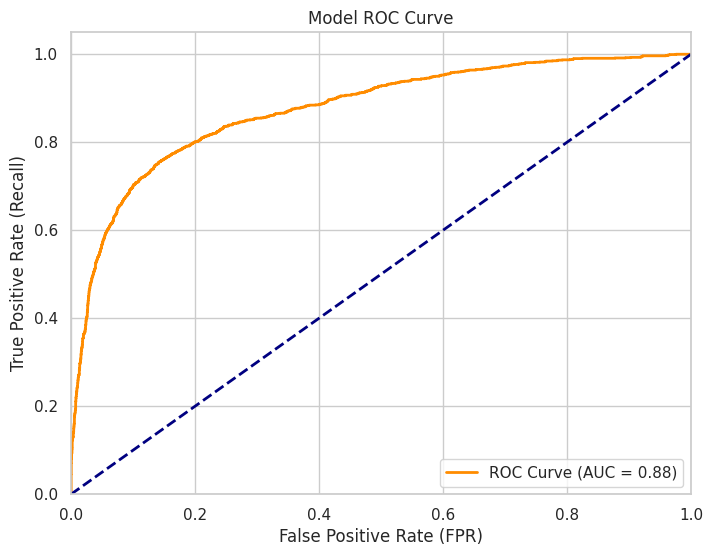

In [31]:
# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Model ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


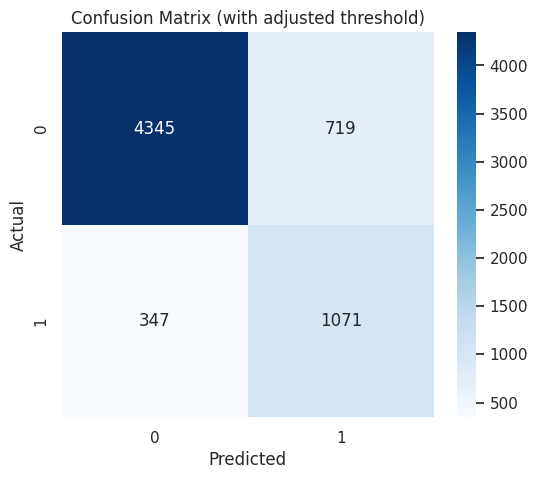

In [32]:
# Confusion matrix with adjusted threshold
cm = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (with adjusted threshold)')
plt.show()

## 🧠 Interpretando os coeficientes do modelo

Uma das grandes vantagens da Regressão Logística é a **explicabilidade**.  
Cada coeficiente representa o **impacto de uma variável** na probabilidade de inadimplência:

- Coeficiente **positivo**: aumenta a chance de inadimplência
- Coeficiente **negativo**: reduz a chance de inadimplência
- Coeficiente **próximo de 0**: pouca influência no modelo

Vamos extrair e visualizar os coeficientes agora.


In [34]:
# Accessing the pipeline model and preprocessor
classifier = pipeline.named_steps['classifier']
preprocessor = pipeline.named_steps['preprocessor']

# Getting feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Creating a dataframe with coefficients
coef_df = pd.DataFrame({
'feature': feature_names,
'coefficient': classifier.coef_[0]
}).sort_values(by='coefficient', ascending=False)

# Displaying the 10 largest and smallest coefficients
pd.concat([coef_df.head(10), coef_df.tail(10)])

,feature,coefficient
22,cat__loan_grade_G,2.666100
3,num__loan_percent_income,0.877925
21,cat__loan_grade_F,0.835654
9,cat__person_home_ownership_RENT,0.784795
20,cat__loan_grade_E,0.617763
7,cat__person_home_ownership_OTHER,0.539146
12,cat__loan_intent_HOMEIMPROVEMENT,0.513957
19,cat__loan_grade_D,0.421650
10,cat__loan_intent_DEBTCONSOLIDATION,0.376394
2,num__loan_int_rate,0.330268


## 🔍 O que os coeficientes revelam?

Os coeficientes da regressão logística mostram o impacto de cada variável na **probabilidade de inadimplência**:

- Coeficientes **positivos** aumentam o risco de inadimplência
- Coeficientes **negativos** indicam menor risco
- Quanto mais distante de zero, **maior a influência no modelo**

---

### 🔺 Variáveis que mais **aumentam o risco**:

- `loan_grade_G` → o coeficiente mais alto (2.66), reforçando que **empréstimos de grade G têm altíssimo risco**
- `loan_percent_income` → quanto maior o valor do empréstimo em relação à renda, maior o risco
- `loan_grade_F` e `E` também aparecem com pesos altos, mostrando uma **escala de risco crescente**
- `person_home_ownership_RENT` → inquilinos tendem a ter maior risco que proprietários
- `loan_intent_HOMEIMPROVEMENT` e `DEBTCONSOLIDATION` → também aparecem com peso positivo, sugerindo maior risco em certos tipos de finalidade de crédito
- `loan_int_rate` → taxas de juros mais altas são atribuídas a perfis de maior risco, e o modelo confirma isso

---

### 🔻 Variáveis que mais **reduzem o risco**:

- `loan_grade_A`, `B`, `C` → notas de crédito melhores estão claramente associadas a menor inadimplência
- `person_home_ownership_OWN` → ser proprietário está fortemente relacionado à estabilidade e menor risco
- `log_income` → quanto maior a renda (log transformada), menor o risco de inadimplência
- `loan_intent_EDUCATION` → objetivo educacional aparece como um dos menos arriscados
- `loan_intent_VENTURE` também aparece como negativo aqui, mas pode ser interpretado como um red flag mais sutil (possivelmente correlação com renda mais alta ou menor histórico)

---

📌 **Insight importante:** O histórico de inadimplência (`cb_person_default_on_file_Y`) tem coeficiente **levemente negativo**, indicando que, no contexto desse modelo, **ele não é um fator decisivo isolado** — pode ser que muitos desses clientes estejam em situação de recuperação ou tenham outros fatores que compensam.

---


# ✅ Conclusão Final

Este projeto entregou uma solução robusta, interpretável e alinhada com diretrizes regulatórias para previsão de inadimplência.

---

## 🧩 Etapas realizadas

- Análise exploratória completa com identificação de outliers e dados faltantes
- Transformação logarítmica em variáveis enviesadas
- Pré-processamento cuidadoso com `Pipeline` e `ColumnTransformer`
- Modelagem com **Regressão Logística**, conforme exigência da Superintendência de Banca e Seguros (SBS)
- Ajuste do threshold com o **Índice de Youden**, focando em redução de falsos negativos
- Interpretação dos coeficientes com insights aplicáveis a decisões de negócio

---

## 💼 Impacto para a operação de crédito

> O modelo atinge **84% de acurácia ajustada**, com recall de **76%**, oferecendo uma ferramenta valiosa para **redução de risco operacional**, **aumento da transparência** e **melhor controle regulatório**.

É possível usá-lo como:

- **Sistema de apoio à decisão** em concessão de crédito
- Base para políticas automatizadas com regras justificáveis
- Módulo integrado a plataformas de crédito, com relatórios explicativos

---

🔍 **Esse projeto é um exemplo de como a ciência de dados pode transformar decisões financeiras em processos mais justos, eficientes e explicáveis.**
